# Topological Exploratory Data Analysis

Mathieu Carrière, https://mathieucarriere.github.io/website/

In [1]:
from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
from gudhi import bottleneck_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
verbose = False # set it to True for debug information

In this notebook, we will see how to use Gudhi in order to perform topological dimension reduction: we will compute simplicial complex approximations of point cloud / distance matrices. These complexes will be either [Mapper complexes](https://diglib.eg.org/handle/10.2312/SPBG.SPBG07.091-100) or [Graph Induced complexes](http://web.cse.ohio-state.edu/~dey.8/GIC/gic.html). Both complexes use covers of the initial space (such as Voronoi partitions or preimages of filter functions), and use these covers to generate simplicial complexes, either by taking the nerve (Mapper) or by checking the presence of colored cliques (Graph Induced). 

Gudhi can handle both point clouds and distance matrices. Let's start with a point cloud.

# Point cloud

Load an example point cloud.

In [3]:
X = np.loadtxt('datasets/human.txt')
X = np.hstack([X[:,0:1], X[:,2:3], X[:,1:2]])

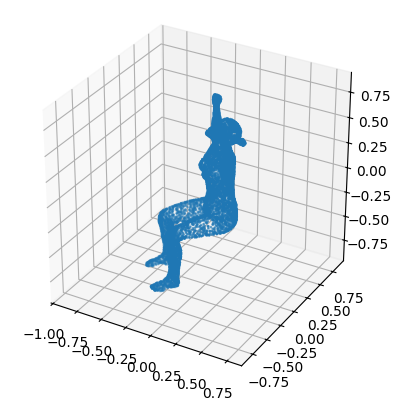

In [4]:
def set_axes_equal(ax: plt.Axes):
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1.0, 1.0, 1.0])
ax.scatter(X[::2,1], X[::2,0], X[::2,2], s=1)
set_axes_equal(ax)
plt.show()

We will use the height function to color the complex nodes.

In [5]:
height = X[:,2]

We next provide different configurations for computing cover complexes:

Graph Induced complex with a Voronoi partition with 100 randomly sampled germs and Rips graph obtained with automatic threshold. 

In [6]:
cover_complex = GraphInducedComplex(
    input_type='point cloud', cover='voronoi', min_points_per_node=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    voronoi_samples=100, verbose=verbose)

In [7]:
_ = cover_complex.fit(X, filter=height, color=height)

Graph Induced complex with a preimage partition with automatic resolution and Rips graph obtained with automatic threshold. 

In [8]:
cover_complex = GraphInducedComplex(
    input_type='point cloud', cover='functional', min_points_per_node=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    resolution=None, gain=0., verbose=verbose)

In [9]:
_ = cover_complex.fit(X, filter=height, color=height)

Mapper complex with a preimage cover with automatic resolution and hierarchical clustering obtained with automatic threshold. 

In [10]:
cover_complex = MapperComplex(
    input_type='point cloud', min_points_per_node=0,
    clustering=None, N=100, beta=0., C=10,
    filter_bnds=None, resolutions=None, gains=None,
    verbose=verbose)

In [11]:
_ = cover_complex.fit(X, filters=height, colors=height)

# Distance matrix

We can actually compute the same complexes using only the pairwise distances between points.

In [12]:
from sklearn.metrics import pairwise_distances

In [13]:
D = pairwise_distances(X)

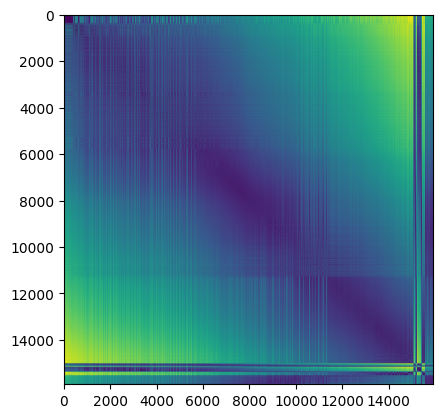

In [14]:
plt.figure()
plt.imshow(D)
plt.show()

This time, color is given by eccentricity.

In [15]:
ecc = D.max(axis=0)

Graph Induced complex with a preimage partition with automatic resolution and Rips graph obtained with automatic threshold. 

In [16]:
cover_complex = GraphInducedComplex(
    input_type='distance matrix', cover='functional', min_points_per_node=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    resolution=None, gain=0., verbose=verbose)

In [17]:
_ = cover_complex.fit(D, filter=ecc, color=ecc)

Graph Induced complex with a Voronoi partition with 100 randomly sampled germs and Rips graph obtained with automatic threshold. 

In [18]:
cover_complex = GraphInducedComplex(
    input_type='distance matrix', cover='voronoi', min_points_per_node=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    voronoi_samples=100, verbose=verbose)

In [19]:
_ = cover_complex.fit(D, filter=ecc, color=ecc)

Mapper complex with a preimage cover with automatic resolution and hierarchical clustering obtained with automatic threshold. 

In [20]:
cover_complex = MapperComplex(
    input_type='distance matrix', min_points_per_node=0,
    clustering=None, N=100, beta=0., C=10,
    filter_bnds=None, resolutions=None, gains=None, verbose=verbose)

In [21]:
_ = cover_complex.fit(D, filters=ecc, colors=ecc)

# More than one filter

Mapper complex with a preimage cover with automatic resolution from a 2D function and hierarchical clustering obtained with automatic threshold. 

In [22]:
filt2d = np.hstack([height[:,np.newaxis],X[:,0:1]])

In [23]:
cover_complex = MapperComplex(
    input_type='point cloud', min_points_per_node=0,
    clustering=None, N=100, beta=0., C=10,
    filter_bnds=None, resolutions=[20,2], gains=None, verbose=verbose)

In [24]:
_ = cover_complex.fit(X, filters=filt2d, colors=filt2d)

# Visualization

You can visualize the complex in three different ways with Gudhi.

1. You can use Python package `networkx`.

In [25]:
import networkx as nx

In [26]:
G = cover_complex.get_networkx()

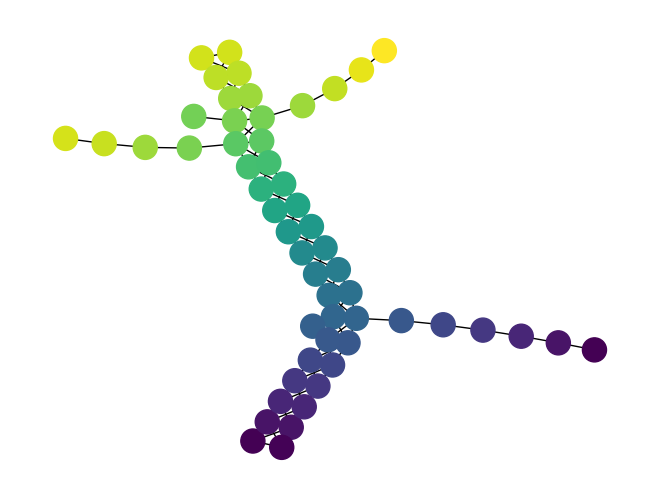

In [27]:
plt.figure()
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info_[v]["colors"][0] for v in G.nodes()])
plt.show()

2. You can create a DOT file that can be processed later with `neato` to produce a PDF.

In [28]:
cover_complex.save_to_dot(file_name="human", color_name="color")

In [29]:
!neato -Tpdf human.dot -o human.pdf

3. You can create an HTML file and visualize it in browser.

In [30]:
cover_complex.save_to_html(file_name="human", data_name="human", cover_name="uniform", color_name="height")

'human.html' is generated. You can now use your favorite web browser to visualize it.


In [31]:
from IPython.display import IFrame
IFrame(src="human.html", width='100%', height='500px')

Alternatively, you can create a TXT file that you can process later with our KeplerMapper wrapper to produce the HTML file.

In [32]:
cover_complex.save_to_txt(file_name="human", data_name="human", cover_name="uniform", color_name="height")

In [33]:
!python ./utils/KeplerMapperVisuFromTxtFile.py -f human.txt

'human.html' is generated. You can now use your favorite web browser to visualize it.


# Topological features

In this section, we will do a variety of post-processing, statistical tasks for the computed cover complex, including, e.g., computing the topological features and/or assessing their stability. For these operations, we will need a set of helper functions, which we define below.

In [34]:
cover_complex = MapperComplex(
    input_type='point cloud', min_points_per_node=0,
    clustering=None, N=100, beta=0., C=10,
    filter_bnds=None, resolutions=None, gains=None,
    verbose=verbose)

In [35]:
_ = cover_complex.fit(X, filters=height, colors=height)

In [36]:
cover_complex.data = X

In [37]:
from scipy.sparse.csgraph    import dijkstra, shortest_path, connected_components
from scipy.stats             import ks_2samp

def find(i, parents):
    if parents[i] == i:
        return i
    else:
        return find(parents[i], parents)

def union(i, j, parents, f):
    if f[i] <= f[j]:
        parents[j] = i
    else:
        parents[i] = j
        
def compute_topological_features(M, threshold=0.):
    """
    Compute the topological features (connected components, up/down branches, loops) of the 1-skeleton of the cover complex. Connected components and loops are computed with scipy functions, and branches are detected with Union-Find and 0-dimensional persistence of the 1-skeleton.
    Parameters:
        threshold (float): any topological feature whose size is less than this parameter (relative to the first color function) will be discarded.
    Returns:
        dgm (list of (dim,(a,b)) tuples): list of feature characteristics. dim is the topological dimension of the feature (0 for CCs and branches, 1 for loops), a,b are the min and max of the first color function along the feature.
        bnds (list of lists): list of feature points. Each element of this list is the list of point IDs forming the corresponding feature. 
    """
    st = M.simplex_tree_
    num_nodes = st.num_vertices()
    function, namefunc, invnamefunc = {}, {}, {}
    nodeID = 0
    for (s,_) in st.get_skeleton(0):
        namefunc[s[0]] = nodeID
        invnamefunc[nodeID] = s[0]
        function[s[0]] = M.node_info_[s[0]]["colors"][0]
        nodeID += 1
    dgm, bnd = [], []

    # connected_components
    A = np.zeros([num_nodes, num_nodes])
    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            A[namefunc[splx[0]], namefunc[splx[1]]] = 1
            A[namefunc[splx[1]], namefunc[splx[0]]] = 1
    _, ccs = connected_components(A, directed=False)
    for ccID in np.unique(ccs):
        pts = np.argwhere(ccs == ccID).flatten()
        vals = [function[invnamefunc[p]] for p in pts]
        if np.abs(min(vals) - max(vals)) >= threshold:
            dgm.append((0, (min(vals), max(vals))))
            bnd.append([invnamefunc[p] for p in pts])

    # loops
    G = M.get_networkx()
    try:
        from networkx import cycle_basis
        bndall = cycle_basis(G)
        for pts in bndall:
            vals = [function[p] for p in pts]
            if np.abs(min(vals) - max(vals)) >= threshold:	
                dgm.append((1,(min(vals), max(vals))))
                bnd.append(pts)
    except ImportError:
        print("Networkx not found, loops not computed")
        
    # branches
    for topo_type in ["downbranch", "upbranch"]:

        lfunction = []
        for i in range(num_nodes):
            lfunction.append(function[invnamefunc[i]])

        # upranch is downbranch of opposite function
        if topo_type == "upbranch":
            lfunction = [-f for f in lfunction]

        # sort vertices according to function values and compute inverse function 
        sorted_idxs = np.argsort(np.array(lfunction))
        inv_sorted_idxs = np.zeros(num_nodes)
        for i in range(num_nodes):
            inv_sorted_idxs[sorted_idxs[i]] = i

        # go through all vertices in ascending function order
        persistence_diag, persistence_set, parents, visited = {}, {}, -np.ones(num_nodes, dtype=np.int32), {}
        for i in range(num_nodes):

            current_pt = sorted_idxs[i]
            neighbors = np.ravel(np.argwhere(A[current_pt,:] == 1))
            lower_neighbors = [n for n in neighbors if inv_sorted_idxs[n] <= i] if len(neighbors) > 0 else []

            # no lower neighbors: current point is a local minimum
            if lower_neighbors == []:
                parents[current_pt] = current_pt

            # some lower neighbors exist
            else:

                # find parent pg of lower neighbors with lowest function value
                neigh_parents = [find(n, parents) for n in lower_neighbors]
                pg = neigh_parents[np.argmin([lfunction[n] for n in neigh_parents])]

                # set parent of current point to pg
                parents[current_pt] = pg

                # for each lower neighbor, we will create a persistence diagram point and corresponding set of nodes
                for neighbor in lower_neighbors:

                    # get parent pn
                    pn = find(neighbor, parents)
                    val = lfunction[pn]
                    persistence_set[pn] = []

                    # we will create persistence set only if parent pn is not local minimum pg
                    if pn != pg:
                        # go through all strictly lower nodes with parent pn
                        for v in sorted_idxs[:i]:
                            if find(v, parents) == pn:
                                # if it is already part of another persistence set, continue
                                try:
                                    visited[v]
                                # else, mark visited and include it in current persistence set
                                except KeyError:
                                    visited[v] = True
                                    persistence_set[pn].append(v)

                        # add current point to persistence set
                        persistence_set[pn].append(current_pt)

                        # do union and create persistence point corresponding to persistence set if persistence is sufficiently large
                        if np.abs(lfunction[pn]-lfunction[current_pt]) >= threshold:
                            persistence_diag[pn] = current_pt
                            union(pg, pn, parents, lfunction)

        for key, val in iter(persistence_diag.items()):
            if topo_type == "downbranch":
                dgm.append((0, (lfunction[key],  lfunction[val])))
            elif topo_type == "upbranch":
                dgm.append((0, (-lfunction[val], -lfunction[key])))
            bnd.append([invnamefunc[v] for v in persistence_set[key]])

    bnd = [list(b) for b in bnd]
    M.persistence_diagram, M.persistence_sets = dgm, bnd 
    return dgm, bnd

def bootstrap_topological_features(M, N):
    """
    Use bootstrap to empirically assess stability of the features. This function computes a distribution of bottleneck distances, that can used afterwards to run tests on each topological feature.
    Parameters:
        N (int): number of bootstrap iterations.
    """

    dgm = M.persistence_diagram
    num_pts, distribution = len(M.data), []
    for bootstrap_id in tqdm(range(N)):

        # Randomly select points
        idxs = np.random.choice(num_pts, size=num_pts, replace=True)
        Xboot = M.data[idxs,:] if M.input_type == "point cloud" else M.data[idxs,:][:,idxs]
        f_boot, c_boot = M.filters[idxs,:], M.colors[idxs,:]
        Mboot = M.__class__(filter_bnds=M.filter_bnds, resolutions=M.resolutions, gains=M.gains, 
                            input_type=M.input_type, clustering=M.clustering).fit(Xboot, filters=f_boot, colors=c_boot)

        # Compute the corresponding persistence diagrams
        dgm_boot, _ = compute_topological_features(Mboot)

        # Compute the bottleneck distance
        npts, npts_boot = len(dgm), len(dgm_boot)
        D1 = np.array([[dgm[pt][1][0], dgm[pt][1][1]] for pt in range(npts)]) 
        D2 = np.array([[dgm_boot[pt][1][0], dgm_boot[pt][1][1]] for pt in range(npts_boot)])
        bottle = bottleneck_distance(D1, D2)
        distribution.append(bottle)
        M.distribution = np.sort(distribution)

def get_distance_from_confidence_level(M, alpha=.95, complex_type='mapper'):
    """
    Compute the bottleneck distance threshold corresponding to a specific confidence level.
    Parameters:
        alpha (float): confidence level.
    Returns:
        distance value (float); each feature whose size is above this distance is sure at confidence level alpha.
    """
    return M.distribution[int(alpha*len(M.distribution))]

def get_confidence_level_from_distance(M, distance):
    """
    Compute the confidence level of a specific bottleneck distance threshold.
    Parameters:
        distance (float): bottleneck distance threshold.
    Returns:
        confidence level (float); each feature whose size is above the distance threshold is sure at this confidence level.
    """
    return len(np.argwhere(M.distribution <= distance))/len(M.distribution)

def get_pvalue(M):
    """
    Compute the p-value, i.e. the opposite of the confidence level of the largest bottleneck distance preserving the topological features.
    Returns:
        p-value (float)
    """
    distancemin = min([np.abs(pt[1][0]-pt[1][1]) for pt in M.persistence_diagram])
    return 1.-M.compute_confidence_from_distance(distancemin)

def compute_differential_coordinates(M, nodes=None, features=None, sparse=False):
    """
    Compute the coordinates that best explain a set of nodes VS the rest of the nodes (in the 1-skeleton of the cover complex) with a Kolmogorov-Smirnov test. Only works if input_type is "point cloud".
    Parameters:
        nodes (list of integers): list of nodes to try. For instance, one can take the list of nodes obtained after calling "compute_topological_features"
        features (list of integers): the coordinates to try. All coordinates are tested if None.
        sparse (bool): set to True if your data is sparse and there will be speedup, otherwise use False.
    Returns:
        features (list of integers): the list of coordinates, ranked from smallest to largest p-values.
        p-values (list of float): the corresponding p-values. 
    """
    if M.input_type == "distance matrix":
        print("Need coordinates for running differential coordinates!")
        raise

    node_info = M.node_info_
    X = M.data
    nodes = [s[0] for s,_ in self.simplex_tree_.get_skeleton(0)] if nodes is None else nodes

    if features is None:
        features = np.arange(X.shape[1])

    list_idxs1 = list(np.unique(np.concatenate([node_info[node_name]["indices"] for node_name in nodes])))
    list_idxs2 = list(set(np.arange(X.shape[0]))-set(list_idxs1))
    pvals = []
    for f in features:
        if sparse:
            Xsp = csr_matrix(X)
            group1 = np.squeeze(np.array(Xsp[list_idxs1,f].todense()))
            group2 = np.squeeze(np.array(Xsp[list_idxs2,f].todense()))
        else:
            group1, group2 = X[list_idxs1,f], X[list_idxs2,f]
        _,pval = ks_2samp(group1, group2)
        pvals.append(pval)
    pvals = np.array(pvals)
    F, P = features[np.argsort(pvals)], np.sort(pvals) 
    return F, P

There are various postprocessing one can do on a cover complex. For instance, one can compute the topological features in the complex. For our human shape, the topological features (identified by computing the persistence of the color function on the complex) are the three branches corresponding to the arms and legs (the lower leg correspond to the whole connected component).

In [38]:
dgm, bnd = compute_topological_features(cover_complex, threshold=0.)

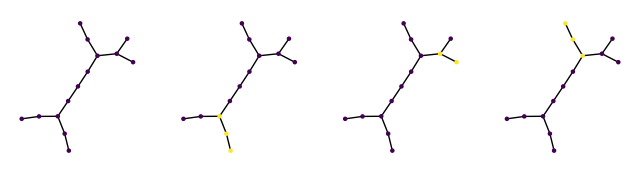

In [39]:
G = cover_complex.get_networkx()
plt.figure(figsize=(8,2))
for idx, bd in enumerate(bnd):
    plt.subplot(1,len(bnd),idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()], node_size=5)
plt.show()

You can also identify the robust topological features by bootstrapping, and select those associated to 95% confidence.

In [40]:
bootstrap_topological_features(cover_complex, 100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


In [41]:
dist = get_distance_from_confidence_level(cover_complex, .85)

In [42]:
bnd_boot = [b for idx, b in enumerate(bnd) if np.abs(.5 * (dgm[idx][1][1]-dgm[idx][1][0])) >= dist]

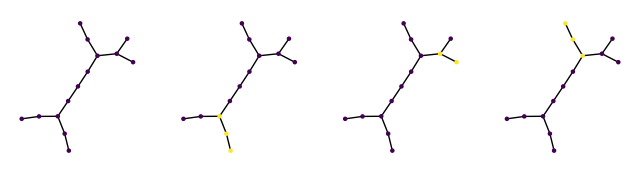

In [43]:
G = cover_complex.get_networkx()
plt.figure(figsize=(8,2))
for idx, bd in enumerate(bnd_boot):
    plt.subplot(1,len(bnd_boot),idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()], node_size=5)
plt.show()

Finally, one can identify the coordinates that best explain a topological feature VS the rest of the complex with a Kolmogorov-Smirnov test. In particular, for each topological feature, we can rank the coordinates with respect to their p-values. 

For instance, coordinate 0 (height) is the one that best distinguishes the topological structures from the rest.

In [44]:
compute_differential_coordinates(cover_complex, nodes=bnd[1])

(array([0, 1, 2]), array([0., 0., 0.]))

In [45]:
compute_differential_coordinates(cover_complex, nodes=bnd[2])

(array([1, 2, 0]), array([0.00000000e+000, 0.00000000e+000, 4.87710222e-147]))

In [46]:
compute_differential_coordinates(cover_complex, nodes=bnd[3])

(array([0, 2, 1]), array([0.00000000e+000, 0.00000000e+000, 3.13211519e-128]))